# **Подготовить Jupyter-блокнот с примерами инференса модели на аномальных данных**

# Установка зависимостей

In [1]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 3.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

# Импорт

In [11]:
import os
import zipfile
import csv
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.io import read_image
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import seaborn as sns

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

# Извлечение информации и содание csv файла для набора данных

In [5]:
zip_test = "DSM-50.zip"
imgzip = zipfile.ZipFile(zip_test, 'r')
imgzip.extractall()

iterator = 0
dataset_root = 'DSM-50'
csv_file_path = 'dataset.csv'
with open(csv_file_path, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['image', 'class'])
    for class_name in os.listdir(dataset_root):
        class_path = os.path.join(dataset_root, class_name)
        if os.path.isdir(class_path):
            iterator = iterator + 1
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                if os.path.isfile(image_path):
                    relative_image_path = os.path.relpath(image_path, dataset_root)
                    csv_writer.writerow([relative_image_path, iterator])

# Класс для создания кастомного набора данных для работы с pytorch

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, label_column='label'):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.label_column = label_column

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[idx, self.img_labels.columns.get_loc(self.label_column)]
        if isinstance(label, str):
            try:
                label = int(label)
            except ValueError:
                print(label)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

# Определение модели

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False

        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 64)
        )

    def forward(self, x):
        x = self.resnet(x)
        return x

# Определяем функции обучения и тестирования

In [8]:
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch, loss_history):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        if batch_idx % 20 == 0:
            print(
                "Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(
                    epoch, batch_idx, loss.item(), mining_func.num_triplets
                )
            )

def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

def plot_loss_history(loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss over Time')
    plt.legend()
    plt.show()

def test(train_set, test_set, model, accuracy_calculator, acc):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, test_labels, train_embeddings, train_labels, False
    )
    acc.append(accuracies["precision_at_1"])
    print("Test set accuracy = {}".format(accuracies["precision_at_1"]))

def plot_accuracy_history(accuracy):
    plt.figure(figsize=(10, 5))
    plt.plot(accuracy, label='Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over time')
    plt.legend()
    plt.show()

# Подготавливаем данные для обучения

In [9]:
# Разбиение данных
annotations_file = "dataset.csv"
img_dir = "DSM-50"
label_column = 'class'

# Чтение аннотаций и разбиение на обучающую и валидационную части
annotations = pd.read_csv(annotations_file)
train_annotations, val_annotations = train_test_split(annotations, test_size=0.4, stratify=annotations[label_column])

# Сохранение временных файлов с разметками
train_annotations_file = "train_dataset.csv"
val_annotations_file = "val_dataset.csv"
train_annotations.to_csv(train_annotations_file, index=False)
val_annotations.to_csv(val_annotations_file, index=False)

# Аугментации данных
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Аугментации для валидационной выборки
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Создание датасетов
train_dataset = CustomImageDataset(train_annotations_file, img_dir, transform=train_transform, label_column=label_column)
val_dataset = CustomImageDataset(val_annotations_file, img_dir, transform=val_transform, label_column=label_column)

# Создание DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Обучение и тестирование

In [12]:
# Подготовка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Параметры обучения
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Понижение learning rate
num_epochs = 500

distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)

loss_history = []
acc = []

# Обучение модели
for epoch in range(1, num_epochs + 1):
    train(model, loss_func, mining_func, device, train_loader, optimizer, epoch, loss_history)
    test(train_dataset, val_dataset, model, accuracy_calculator, acc)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.79it/s]
/usr/local/lib/python3.10/dist-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)


Test set accuracy = 0.36923076923076925
Epoch 2 Iteration 0: Loss = 0.06747492402791977, Number of mined triplets = 17


100%|██████████| 3/3 [00:00<00:00,  4.76it/s]


Test set accuracy = 0.38461538461538464
Epoch 3 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Test set accuracy = 0.2923076923076923
Epoch 4 Iteration 0: Loss = 0.1234998106956482, Number of mined triplets = 7


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Test set accuracy = 0.3384615384615385
Epoch 5 Iteration 0: Loss = 0.11924315989017487, Number of mined triplets = 7


100%|██████████| 3/3 [00:00<00:00,  4.69it/s]


Test set accuracy = 0.3384615384615385
Epoch 6 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


Test set accuracy = 0.24615384615384617
Epoch 7 Iteration 0: Loss = 0.10268095135688782, Number of mined triplets = 24


100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Test set accuracy = 0.3076923076923077
Epoch 8 Iteration 0: Loss = 0.07960814982652664, Number of mined triplets = 16


100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


Test set accuracy = 0.2923076923076923
Epoch 9 Iteration 0: Loss = 0.12889371812343597, Number of mined triplets = 9


100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


Test set accuracy = 0.3076923076923077
Epoch 10 Iteration 0: Loss = 0.09006261825561523, Number of mined triplets = 16


100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Test set accuracy = 0.27692307692307694
Epoch 11 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Test set accuracy = 0.3076923076923077
Epoch 12 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Test set accuracy = 0.3076923076923077
Epoch 13 Iteration 0: Loss = 0.10663667321205139, Number of mined triplets = 13


100%|██████████| 3/3 [00:00<00:00,  4.80it/s]


Test set accuracy = 0.2923076923076923
Epoch 14 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


Test set accuracy = 0.3230769230769231
Epoch 15 Iteration 0: Loss = 0.07616081833839417, Number of mined triplets = 8


100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Test set accuracy = 0.26153846153846155
Epoch 16 Iteration 0: Loss = 0.09337928146123886, Number of mined triplets = 11


100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Test set accuracy = 0.27692307692307694
Epoch 17 Iteration 0: Loss = 0.10158926248550415, Number of mined triplets = 12


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Test set accuracy = 0.35384615384615387
Epoch 18 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


Test set accuracy = 0.38461538461538464
Epoch 19 Iteration 0: Loss = 0.11428950726985931, Number of mined triplets = 13


100%|██████████| 3/3 [00:00<00:00,  4.81it/s]


Test set accuracy = 0.26153846153846155
Epoch 20 Iteration 0: Loss = 0.0849279835820198, Number of mined triplets = 26


100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


Test set accuracy = 0.2923076923076923
Epoch 21 Iteration 0: Loss = 0.09217222034931183, Number of mined triplets = 9


100%|██████████| 3/3 [00:00<00:00,  4.80it/s]


Test set accuracy = 0.2923076923076923
Epoch 22 Iteration 0: Loss = 0.09807644784450531, Number of mined triplets = 18


100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Test set accuracy = 0.2923076923076923
Epoch 23 Iteration 0: Loss = 0.11743250489234924, Number of mined triplets = 23


100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Test set accuracy = 0.2923076923076923
Epoch 24 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.73it/s]


Test set accuracy = 0.3076923076923077
Epoch 25 Iteration 0: Loss = 0.10824605822563171, Number of mined triplets = 29


100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


Test set accuracy = 0.35384615384615387
Epoch 26 Iteration 0: Loss = 0.108143649995327, Number of mined triplets = 10


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Test set accuracy = 0.36923076923076925
Epoch 27 Iteration 0: Loss = 0.13320323824882507, Number of mined triplets = 9


100%|██████████| 3/3 [00:00<00:00,  4.65it/s]


Test set accuracy = 0.3230769230769231
Epoch 28 Iteration 0: Loss = 0.08391959965229034, Number of mined triplets = 19


100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


Test set accuracy = 0.26153846153846155
Epoch 29 Iteration 0: Loss = 0.1045641154050827, Number of mined triplets = 16


100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


Test set accuracy = 0.35384615384615387
Epoch 30 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.73it/s]


Test set accuracy = 0.4
Epoch 31 Iteration 0: Loss = 0.08000335842370987, Number of mined triplets = 15


100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Test set accuracy = 0.38461538461538464
Epoch 32 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.67it/s]


Test set accuracy = 0.3384615384615385
Epoch 33 Iteration 0: Loss = 0.1004786342382431, Number of mined triplets = 13


100%|██████████| 3/3 [00:00<00:00,  4.65it/s]


Test set accuracy = 0.36923076923076925
Epoch 34 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.58it/s]


Test set accuracy = 0.35384615384615387
Epoch 35 Iteration 0: Loss = 0.08349235355854034, Number of mined triplets = 25


100%|██████████| 3/3 [00:00<00:00,  4.81it/s]


Test set accuracy = 0.3230769230769231
Epoch 36 Iteration 0: Loss = 0.1280146986246109, Number of mined triplets = 9


100%|██████████| 3/3 [00:00<00:00,  4.01it/s]


Test set accuracy = 0.35384615384615387
Epoch 37 Iteration 0: Loss = 0.08079084753990173, Number of mined triplets = 10


100%|██████████| 3/3 [00:00<00:00,  4.67it/s]


Test set accuracy = 0.36923076923076925
Epoch 38 Iteration 0: Loss = 0.059114765375852585, Number of mined triplets = 7


100%|██████████| 3/3 [00:00<00:00,  4.54it/s]


Test set accuracy = 0.36923076923076925
Epoch 39 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


Test set accuracy = 0.35384615384615387
Epoch 40 Iteration 0: Loss = 0.1135222315788269, Number of mined triplets = 11


100%|██████████| 3/3 [00:00<00:00,  4.69it/s]


Test set accuracy = 0.35384615384615387
Epoch 41 Iteration 0: Loss = 0.07251015305519104, Number of mined triplets = 13


100%|██████████| 3/3 [00:00<00:00,  4.75it/s]


Test set accuracy = 0.4461538461538462
Epoch 42 Iteration 0: Loss = 0.10170034319162369, Number of mined triplets = 25


100%|██████████| 3/3 [00:01<00:00,  2.78it/s]


Test set accuracy = 0.38461538461538464
Epoch 43 Iteration 0: Loss = 0.07184112071990967, Number of mined triplets = 14


100%|██████████| 3/3 [00:00<00:00,  4.56it/s]


Test set accuracy = 0.3230769230769231
Epoch 44 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.75it/s]


Test set accuracy = 0.36923076923076925
Epoch 45 Iteration 0: Loss = 0.09273535758256912, Number of mined triplets = 11


100%|██████████| 3/3 [00:00<00:00,  3.60it/s]


Test set accuracy = 0.38461538461538464
Epoch 46 Iteration 0: Loss = 0.15024138987064362, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.65it/s]


Test set accuracy = 0.36923076923076925
Epoch 47 Iteration 0: Loss = 0.08858869969844818, Number of mined triplets = 12


100%|██████████| 3/3 [00:00<00:00,  4.41it/s]


Test set accuracy = 0.35384615384615387
Epoch 48 Iteration 0: Loss = 0.08986552059650421, Number of mined triplets = 22


100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Test set accuracy = 0.3076923076923077
Epoch 49 Iteration 0: Loss = 0.06357868015766144, Number of mined triplets = 12


100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


Test set accuracy = 0.38461538461538464
Epoch 50 Iteration 0: Loss = 0.09812242537736893, Number of mined triplets = 15


100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


Test set accuracy = 0.36923076923076925
Epoch 51 Iteration 0: Loss = 0.062018390744924545, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


Test set accuracy = 0.35384615384615387
Epoch 52 Iteration 0: Loss = 0.0994868129491806, Number of mined triplets = 26


100%|██████████| 3/3 [00:00<00:00,  4.05it/s]


Test set accuracy = 0.38461538461538464
Epoch 53 Iteration 0: Loss = 0.12122511863708496, Number of mined triplets = 20


100%|██████████| 3/3 [00:00<00:00,  4.55it/s]


Test set accuracy = 0.3384615384615385
Epoch 54 Iteration 0: Loss = 0.09573143720626831, Number of mined triplets = 12


100%|██████████| 3/3 [00:00<00:00,  4.47it/s]


Test set accuracy = 0.36923076923076925
Epoch 55 Iteration 0: Loss = 0.09838087111711502, Number of mined triplets = 15


100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


Test set accuracy = 0.4307692307692308
Epoch 56 Iteration 0: Loss = 0.08522916585206985, Number of mined triplets = 18


100%|██████████| 3/3 [00:00<00:00,  4.65it/s]


Test set accuracy = 0.36923076923076925
Epoch 57 Iteration 0: Loss = 0.13366562128067017, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Test set accuracy = 0.36923076923076925
Epoch 58 Iteration 0: Loss = 0.0983026921749115, Number of mined triplets = 26


100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


Test set accuracy = 0.3076923076923077
Epoch 59 Iteration 0: Loss = 0.08793289214372635, Number of mined triplets = 26


100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


Test set accuracy = 0.3076923076923077
Epoch 60 Iteration 0: Loss = 0.08108296990394592, Number of mined triplets = 12


100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


Test set accuracy = 0.2923076923076923
Epoch 61 Iteration 0: Loss = 0.08728797733783722, Number of mined triplets = 14


100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


Test set accuracy = 0.3230769230769231
Epoch 62 Iteration 0: Loss = 0.11674558371305466, Number of mined triplets = 11


100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


Test set accuracy = 0.36923076923076925
Epoch 63 Iteration 0: Loss = 0.11135600507259369, Number of mined triplets = 19


100%|██████████| 3/3 [00:00<00:00,  4.42it/s]


Test set accuracy = 0.4
Epoch 64 Iteration 0: Loss = 0.11207839101552963, Number of mined triplets = 44


100%|██████████| 3/3 [00:00<00:00,  4.05it/s]


Test set accuracy = 0.3384615384615385
Epoch 65 Iteration 0: Loss = 0.09433163702487946, Number of mined triplets = 13


100%|██████████| 3/3 [00:00<00:00,  4.47it/s]


Test set accuracy = 0.3230769230769231
Epoch 66 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Test set accuracy = 0.35384615384615387
Epoch 67 Iteration 0: Loss = 0.11964736878871918, Number of mined triplets = 23


100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


Test set accuracy = 0.35384615384615387
Epoch 68 Iteration 0: Loss = 0.08585617691278458, Number of mined triplets = 20


100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Test set accuracy = 0.4
Epoch 69 Iteration 0: Loss = 0.08608503639698029, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


Test set accuracy = 0.3384615384615385
Epoch 70 Iteration 0: Loss = 0.13895004987716675, Number of mined triplets = 11


100%|██████████| 3/3 [00:00<00:00,  4.35it/s]


Test set accuracy = 0.3384615384615385
Epoch 71 Iteration 0: Loss = 0.08156661689281464, Number of mined triplets = 12


100%|██████████| 3/3 [00:00<00:00,  4.54it/s]


Test set accuracy = 0.38461538461538464
Epoch 72 Iteration 0: Loss = 0.08478505909442902, Number of mined triplets = 13


100%|██████████| 3/3 [00:00<00:00,  4.51it/s]


Test set accuracy = 0.38461538461538464
Epoch 73 Iteration 0: Loss = 0.08557792752981186, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.65it/s]


Test set accuracy = 0.36923076923076925
Epoch 74 Iteration 0: Loss = 0.10386940836906433, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Test set accuracy = 0.38461538461538464
Epoch 75 Iteration 0: Loss = 0.0785675048828125, Number of mined triplets = 10


100%|██████████| 3/3 [00:00<00:00,  4.55it/s]


Test set accuracy = 0.38461538461538464
Epoch 76 Iteration 0: Loss = 0.0680912584066391, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


Test set accuracy = 0.4153846153846154
Epoch 77 Iteration 0: Loss = 0.11247439682483673, Number of mined triplets = 4


100%|██████████| 3/3 [00:01<00:00,  2.75it/s]


Test set accuracy = 0.35384615384615387
Epoch 78 Iteration 0: Loss = 0.08400774747133255, Number of mined triplets = 15


100%|██████████| 3/3 [00:00<00:00,  4.43it/s]


Test set accuracy = 0.4
Epoch 79 Iteration 0: Loss = 0.09334014356136322, Number of mined triplets = 13


100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


Test set accuracy = 0.3384615384615385
Epoch 80 Iteration 0: Loss = 0.14203786849975586, Number of mined triplets = 3


100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Test set accuracy = 0.2923076923076923
Epoch 81 Iteration 0: Loss = 0.07075747847557068, Number of mined triplets = 17


100%|██████████| 3/3 [00:00<00:00,  4.51it/s]


Test set accuracy = 0.4
Epoch 82 Iteration 0: Loss = 0.13321572542190552, Number of mined triplets = 8


100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Test set accuracy = 0.4461538461538462
Epoch 83 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Test set accuracy = 0.4461538461538462
Epoch 84 Iteration 0: Loss = 0.11558205634355545, Number of mined triplets = 15


100%|██████████| 3/3 [00:00<00:00,  4.55it/s]


Test set accuracy = 0.3384615384615385
Epoch 85 Iteration 0: Loss = 0.08808564394712448, Number of mined triplets = 8


100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


Test set accuracy = 0.36923076923076925
Epoch 86 Iteration 0: Loss = 0.08662386238574982, Number of mined triplets = 7


100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Test set accuracy = 0.46153846153846156
Epoch 87 Iteration 0: Loss = 0.09121312946081161, Number of mined triplets = 10


100%|██████████| 3/3 [00:00<00:00,  4.55it/s]


Test set accuracy = 0.36923076923076925
Epoch 88 Iteration 0: Loss = 0.08092105388641357, Number of mined triplets = 20


100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


Test set accuracy = 0.4307692307692308
Epoch 89 Iteration 0: Loss = 0.09988036751747131, Number of mined triplets = 18


100%|██████████| 3/3 [00:00<00:00,  4.56it/s]


Test set accuracy = 0.38461538461538464
Epoch 90 Iteration 0: Loss = 0.055658042430877686, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.43it/s]


Test set accuracy = 0.4153846153846154
Epoch 91 Iteration 0: Loss = 0.05915209650993347, Number of mined triplets = 23


100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


Test set accuracy = 0.4153846153846154
Epoch 92 Iteration 0: Loss = 0.14938697218894958, Number of mined triplets = 11


100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Test set accuracy = 0.36923076923076925
Epoch 93 Iteration 0: Loss = 0.07201842218637466, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


Test set accuracy = 0.4307692307692308
Epoch 94 Iteration 0: Loss = 0.08812788128852844, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


Test set accuracy = 0.35384615384615387
Epoch 95 Iteration 0: Loss = 0.12669765949249268, Number of mined triplets = 16


100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


Test set accuracy = 0.4307692307692308
Epoch 96 Iteration 0: Loss = 0.06671977043151855, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


Test set accuracy = 0.4307692307692308
Epoch 97 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Test set accuracy = 0.4461538461538462
Epoch 98 Iteration 0: Loss = 0.10553431510925293, Number of mined triplets = 10


100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


Test set accuracy = 0.4
Epoch 99 Iteration 0: Loss = 0.06542207300662994, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Test set accuracy = 0.38461538461538464
Epoch 100 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Test set accuracy = 0.4307692307692308
Epoch 101 Iteration 0: Loss = 0.06940098851919174, Number of mined triplets = 11


100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


Test set accuracy = 0.4153846153846154
Epoch 102 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.75it/s]


Test set accuracy = 0.4153846153846154
Epoch 103 Iteration 0: Loss = 0.08564087748527527, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Test set accuracy = 0.38461538461538464
Epoch 104 Iteration 0: Loss = 0.09643959999084473, Number of mined triplets = 16


100%|██████████| 3/3 [00:00<00:00,  4.69it/s]


Test set accuracy = 0.4153846153846154
Epoch 105 Iteration 0: Loss = 0.044666822999715805, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


Test set accuracy = 0.35384615384615387
Epoch 106 Iteration 0: Loss = 0.1366993635892868, Number of mined triplets = 7


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Test set accuracy = 0.4153846153846154
Epoch 107 Iteration 0: Loss = 0.051019031554460526, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.73it/s]


Test set accuracy = 0.3230769230769231
Epoch 108 Iteration 0: Loss = 0.11721239238977432, Number of mined triplets = 10


100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


Test set accuracy = 0.35384615384615387
Epoch 109 Iteration 0: Loss = 0.09662219882011414, Number of mined triplets = 8


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Test set accuracy = 0.4153846153846154
Epoch 110 Iteration 0: Loss = 0.061852890998125076, Number of mined triplets = 10


100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


Test set accuracy = 0.3384615384615385
Epoch 111 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.52it/s]


Test set accuracy = 0.38461538461538464
Epoch 112 Iteration 0: Loss = 0.06277330219745636, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


Test set accuracy = 0.4153846153846154
Epoch 113 Iteration 0: Loss = 0.051761358976364136, Number of mined triplets = 6


100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


Test set accuracy = 0.35384615384615387
Epoch 114 Iteration 0: Loss = 0.06901416182518005, Number of mined triplets = 12


100%|██████████| 3/3 [00:00<00:00,  4.69it/s]


Test set accuracy = 0.49230769230769234
Epoch 115 Iteration 0: Loss = 0.0692724734544754, Number of mined triplets = 20


100%|██████████| 3/3 [00:00<00:00,  4.55it/s]


Test set accuracy = 0.4
Epoch 116 Iteration 0: Loss = 0.11344323307275772, Number of mined triplets = 9


100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Test set accuracy = 0.38461538461538464
Epoch 117 Iteration 0: Loss = 0.05085381865501404, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.56it/s]


Test set accuracy = 0.4307692307692308
Epoch 118 Iteration 0: Loss = 0.04934975504875183, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.44it/s]


Test set accuracy = 0.4
Epoch 119 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  3.91it/s]


Test set accuracy = 0.4153846153846154
Epoch 120 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Test set accuracy = 0.4
Epoch 121 Iteration 0: Loss = 0.047962162643671036, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


Test set accuracy = 0.4
Epoch 122 Iteration 0: Loss = 0.08418732136487961, Number of mined triplets = 5


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Test set accuracy = 0.4153846153846154
Epoch 123 Iteration 0: Loss = 0.10813512653112411, Number of mined triplets = 7


100%|██████████| 3/3 [00:00<00:00,  4.14it/s]


Test set accuracy = 0.47692307692307695
Epoch 124 Iteration 0: Loss = 0.08219128102064133, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.56it/s]


Test set accuracy = 0.36923076923076925
Epoch 125 Iteration 0: Loss = 0.051738541573286057, Number of mined triplets = 8


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Test set accuracy = 0.35384615384615387
Epoch 126 Iteration 0: Loss = 0.06888473778963089, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Test set accuracy = 0.4307692307692308
Epoch 127 Iteration 0: Loss = 0.08945603668689728, Number of mined triplets = 8


100%|██████████| 3/3 [00:00<00:00,  4.39it/s]


Test set accuracy = 0.36923076923076925
Epoch 128 Iteration 0: Loss = 0.060281068086624146, Number of mined triplets = 8


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Test set accuracy = 0.3230769230769231
Epoch 129 Iteration 0: Loss = 0.08787885308265686, Number of mined triplets = 14


100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


Test set accuracy = 0.38461538461538464
Epoch 130 Iteration 0: Loss = 0.11353322118520737, Number of mined triplets = 11


100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


Test set accuracy = 0.38461538461538464
Epoch 131 Iteration 0: Loss = 0.09446833282709122, Number of mined triplets = 19


100%|██████████| 3/3 [00:00<00:00,  4.27it/s]


Test set accuracy = 0.4
Epoch 132 Iteration 0: Loss = 0.021198734641075134, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


Test set accuracy = 0.4
Epoch 133 Iteration 0: Loss = 0.08016428351402283, Number of mined triplets = 21


100%|██████████| 3/3 [00:00<00:00,  4.56it/s]


Test set accuracy = 0.4
Epoch 134 Iteration 0: Loss = 0.07435194402933121, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


Test set accuracy = 0.35384615384615387
Epoch 135 Iteration 0: Loss = 0.1100798025727272, Number of mined triplets = 22


100%|██████████| 3/3 [00:00<00:00,  4.52it/s]


Test set accuracy = 0.47692307692307695
Epoch 136 Iteration 0: Loss = 0.08730717748403549, Number of mined triplets = 9


100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Test set accuracy = 0.35384615384615387
Epoch 137 Iteration 0: Loss = 0.06467131525278091, Number of mined triplets = 10


100%|██████████| 3/3 [00:00<00:00,  4.41it/s]


Test set accuracy = 0.4307692307692308
Epoch 138 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Test set accuracy = 0.38461538461538464
Epoch 139 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Test set accuracy = 0.4153846153846154
Epoch 140 Iteration 0: Loss = 0.07095270603895187, Number of mined triplets = 9


100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


Test set accuracy = 0.35384615384615387
Epoch 141 Iteration 0: Loss = 0.10246650129556656, Number of mined triplets = 7


100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


Test set accuracy = 0.4153846153846154
Epoch 142 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.44it/s]


Test set accuracy = 0.36923076923076925
Epoch 143 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.55it/s]


Test set accuracy = 0.4153846153846154
Epoch 144 Iteration 0: Loss = 0.08261159807443619, Number of mined triplets = 27


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Test set accuracy = 0.3384615384615385
Epoch 145 Iteration 0: Loss = 0.07933212071657181, Number of mined triplets = 18


100%|██████████| 3/3 [00:00<00:00,  4.30it/s]


Test set accuracy = 0.4461538461538462
Epoch 146 Iteration 0: Loss = 0.026705866679549217, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.67it/s]


Test set accuracy = 0.47692307692307695
Epoch 147 Iteration 0: Loss = 0.17648299038410187, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Test set accuracy = 0.4153846153846154
Epoch 148 Iteration 0: Loss = 0.04264310002326965, Number of mined triplets = 9


100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


Test set accuracy = 0.4307692307692308
Epoch 149 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.57it/s]


Test set accuracy = 0.4307692307692308
Epoch 150 Iteration 0: Loss = 0.08542919158935547, Number of mined triplets = 13


100%|██████████| 3/3 [00:00<00:00,  4.56it/s]


Test set accuracy = 0.46153846153846156
Epoch 151 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.65it/s]


Test set accuracy = 0.4307692307692308
Epoch 152 Iteration 0: Loss = 0.10978367179632187, Number of mined triplets = 7


100%|██████████| 3/3 [00:00<00:00,  4.44it/s]


Test set accuracy = 0.4
Epoch 153 Iteration 0: Loss = 0.08540606498718262, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.51it/s]


Test set accuracy = 0.4461538461538462
Epoch 154 Iteration 0: Loss = 0.1037287712097168, Number of mined triplets = 17


100%|██████████| 3/3 [00:00<00:00,  4.08it/s]


Test set accuracy = 0.46153846153846156
Epoch 155 Iteration 0: Loss = 0.09084390848875046, Number of mined triplets = 15


100%|██████████| 3/3 [00:00<00:00,  4.47it/s]


Test set accuracy = 0.38461538461538464
Epoch 156 Iteration 0: Loss = 0.09894153475761414, Number of mined triplets = 28


100%|██████████| 3/3 [00:00<00:00,  4.37it/s]


Test set accuracy = 0.46153846153846156
Epoch 157 Iteration 0: Loss = 0.07661841809749603, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


Test set accuracy = 0.38461538461538464
Epoch 158 Iteration 0: Loss = 0.06657934188842773, Number of mined triplets = 10


100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Test set accuracy = 0.46153846153846156
Epoch 159 Iteration 0: Loss = 0.10628332197666168, Number of mined triplets = 6


100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Test set accuracy = 0.49230769230769234
Epoch 160 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


Test set accuracy = 0.4153846153846154
Epoch 161 Iteration 0: Loss = 0.09464579820632935, Number of mined triplets = 9


100%|██████████| 3/3 [00:00<00:00,  4.33it/s]


Test set accuracy = 0.4307692307692308
Epoch 162 Iteration 0: Loss = 0.06327441334724426, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.41it/s]


Test set accuracy = 0.49230769230769234
Epoch 163 Iteration 0: Loss = 0.10087252408266068, Number of mined triplets = 13


100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


Test set accuracy = 0.47692307692307695
Epoch 164 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Test set accuracy = 0.49230769230769234
Epoch 165 Iteration 0: Loss = 0.09017385542392731, Number of mined triplets = 7


100%|██████████| 3/3 [00:00<00:00,  4.32it/s]


Test set accuracy = 0.46153846153846156
Epoch 166 Iteration 0: Loss = 0.06020548567175865, Number of mined triplets = 6


100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


Test set accuracy = 0.46153846153846156
Epoch 167 Iteration 0: Loss = 0.07836814969778061, Number of mined triplets = 7


100%|██████████| 3/3 [00:00<00:00,  4.37it/s]


Test set accuracy = 0.46153846153846156
Epoch 168 Iteration 0: Loss = 0.060463760048151016, Number of mined triplets = 7


100%|██████████| 3/3 [00:00<00:00,  4.39it/s]


Test set accuracy = 0.38461538461538464
Epoch 169 Iteration 0: Loss = 0.005116209387779236, Number of mined triplets = 1


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Test set accuracy = 0.4307692307692308
Epoch 170 Iteration 0: Loss = 0.09449551999568939, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Test set accuracy = 0.47692307692307695
Epoch 171 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Test set accuracy = 0.5384615384615385
Epoch 172 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.15it/s]


Test set accuracy = 0.46153846153846156
Epoch 173 Iteration 0: Loss = 0.03657311946153641, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.48it/s]


Test set accuracy = 0.4461538461538462
Epoch 174 Iteration 0: Loss = 0.03406934440135956, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.30it/s]


Test set accuracy = 0.4461538461538462
Epoch 175 Iteration 0: Loss = 0.07920046150684357, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.48it/s]


Test set accuracy = 0.47692307692307695
Epoch 176 Iteration 0: Loss = 0.08800739794969559, Number of mined triplets = 8


100%|██████████| 3/3 [00:00<00:00,  4.43it/s]


Test set accuracy = 0.5384615384615385
Epoch 177 Iteration 0: Loss = 0.1169373020529747, Number of mined triplets = 6


100%|██████████| 3/3 [00:00<00:00,  4.40it/s]


Test set accuracy = 0.4153846153846154
Epoch 178 Iteration 0: Loss = 0.09723389893770218, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


Test set accuracy = 0.4307692307692308
Epoch 179 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.00it/s]


Test set accuracy = 0.46153846153846156
Epoch 180 Iteration 0: Loss = 0.11182846873998642, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.52it/s]


Test set accuracy = 0.47692307692307695
Epoch 181 Iteration 0: Loss = 0.09943501651287079, Number of mined triplets = 6


100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Test set accuracy = 0.4307692307692308
Epoch 182 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Test set accuracy = 0.35384615384615387
Epoch 183 Iteration 0: Loss = 0.09705280512571335, Number of mined triplets = 8


100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


Test set accuracy = 0.47692307692307695
Epoch 184 Iteration 0: Loss = 0.05510161072015762, Number of mined triplets = 7


100%|██████████| 3/3 [00:00<00:00,  4.52it/s]


Test set accuracy = 0.4307692307692308
Epoch 185 Iteration 0: Loss = 0.022388413548469543, Number of mined triplets = 2


100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


Test set accuracy = 0.49230769230769234
Epoch 186 Iteration 0: Loss = 0.04718045890331268, Number of mined triplets = 8


100%|██████████| 3/3 [00:00<00:00,  4.47it/s]


Test set accuracy = 0.4307692307692308
Epoch 187 Iteration 0: Loss = 0.10180532187223434, Number of mined triplets = 11


100%|██████████| 3/3 [00:00<00:00,  4.44it/s]


Test set accuracy = 0.47692307692307695
Epoch 188 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Test set accuracy = 0.49230769230769234
Epoch 189 Iteration 0: Loss = 0.1111740842461586, Number of mined triplets = 14


100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


Test set accuracy = 0.5384615384615385
Epoch 190 Iteration 0: Loss = 0.0896265059709549, Number of mined triplets = 28


100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


Test set accuracy = 0.49230769230769234
Epoch 191 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Test set accuracy = 0.5230769230769231
Epoch 192 Iteration 0: Loss = 0.051437508314847946, Number of mined triplets = 6


100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Test set accuracy = 0.4461538461538462
Epoch 193 Iteration 0: Loss = 0.10868669301271439, Number of mined triplets = 8


100%|██████████| 3/3 [00:00<00:00,  4.29it/s]


Test set accuracy = 0.49230769230769234
Epoch 194 Iteration 0: Loss = 0.09042159467935562, Number of mined triplets = 14


100%|██████████| 3/3 [00:00<00:00,  4.20it/s]


Test set accuracy = 0.4461538461538462
Epoch 195 Iteration 0: Loss = 0.14131124317646027, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.29it/s]


Test set accuracy = 0.5538461538461539
Epoch 196 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.47it/s]


Test set accuracy = 0.47692307692307695
Epoch 197 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.52it/s]


Test set accuracy = 0.4461538461538462
Epoch 198 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.41it/s]


Test set accuracy = 0.46153846153846156
Epoch 199 Iteration 0: Loss = 0.09878706932067871, Number of mined triplets = 21


100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Test set accuracy = 0.4
Epoch 200 Iteration 0: Loss = 0.07800593227148056, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.42it/s]


Test set accuracy = 0.46153846153846156
Epoch 201 Iteration 0: Loss = 0.088553287088871, Number of mined triplets = 13


100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


Test set accuracy = 0.4153846153846154
Epoch 202 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.40it/s]


Test set accuracy = 0.4461538461538462
Epoch 203 Iteration 0: Loss = 0.06139318645000458, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.56it/s]


Test set accuracy = 0.46153846153846156
Epoch 204 Iteration 0: Loss = 0.0330982431769371, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


Test set accuracy = 0.47692307692307695
Epoch 205 Iteration 0: Loss = 0.11419068276882172, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


Test set accuracy = 0.47692307692307695
Epoch 206 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.40it/s]


Test set accuracy = 0.47692307692307695
Epoch 207 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


Test set accuracy = 0.4461538461538462
Epoch 208 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.44it/s]


Test set accuracy = 0.47692307692307695
Epoch 209 Iteration 0: Loss = 0.12545962631702423, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Test set accuracy = 0.49230769230769234
Epoch 210 Iteration 0: Loss = 0.09177902340888977, Number of mined triplets = 4


100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


Test set accuracy = 0.49230769230769234
Epoch 211 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.42it/s]


Test set accuracy = 0.49230769230769234
Epoch 212 Iteration 0: Loss = 0.08276346325874329, Number of mined triplets = 8


100%|██████████| 3/3 [00:00<00:00,  4.44it/s]


Test set accuracy = 0.46153846153846156
Epoch 213 Iteration 0: Loss = 0.08822062611579895, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


Test set accuracy = 0.5230769230769231
Epoch 214 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


Test set accuracy = 0.4461538461538462
Epoch 215 Iteration 0: Loss = 0.06587352603673935, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Test set accuracy = 0.46153846153846156
Epoch 216 Iteration 0: Loss = 0.010861024260520935, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


Test set accuracy = 0.46153846153846156
Epoch 217 Iteration 0: Loss = 0.05784790217876434, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Test set accuracy = 0.46153846153846156
Epoch 218 Iteration 0: Loss = 0.11347974836826324, Number of mined triplets = 10


100%|██████████| 3/3 [00:00<00:00,  4.25it/s]


Test set accuracy = 0.47692307692307695
Epoch 219 Iteration 0: Loss = 0.10292217880487442, Number of mined triplets = 7


100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Test set accuracy = 0.46153846153846156
Epoch 220 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.30it/s]


Test set accuracy = 0.4153846153846154
Epoch 221 Iteration 0: Loss = 0.09781283885240555, Number of mined triplets = 10


100%|██████████| 3/3 [00:00<00:00,  4.37it/s]


Test set accuracy = 0.47692307692307695
Epoch 222 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Test set accuracy = 0.46153846153846156
Epoch 223 Iteration 0: Loss = 0.09150295704603195, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Test set accuracy = 0.5538461538461539
Epoch 224 Iteration 0: Loss = 0.08879083395004272, Number of mined triplets = 6


100%|██████████| 3/3 [00:00<00:00,  4.37it/s]


Test set accuracy = 0.5076923076923077
Epoch 225 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.25it/s]


Test set accuracy = 0.47692307692307695
Epoch 226 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


Test set accuracy = 0.5076923076923077
Epoch 227 Iteration 0: Loss = 0.07435645908117294, Number of mined triplets = 14


100%|██████████| 3/3 [00:00<00:00,  4.32it/s]


Test set accuracy = 0.47692307692307695
Epoch 228 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


Test set accuracy = 0.47692307692307695
Epoch 229 Iteration 0: Loss = 0.047075800597667694, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Test set accuracy = 0.4307692307692308
Epoch 230 Iteration 0: Loss = 0.05952658876776695, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


Test set accuracy = 0.49230769230769234
Epoch 231 Iteration 0: Loss = 0.10047376155853271, Number of mined triplets = 20


100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


Test set accuracy = 0.47692307692307695
Epoch 232 Iteration 0: Loss = 0.0954221710562706, Number of mined triplets = 5


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Test set accuracy = 0.47692307692307695
Epoch 233 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.55it/s]


Test set accuracy = 0.5076923076923077
Epoch 234 Iteration 0: Loss = 0.13725735247135162, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.36it/s]


Test set accuracy = 0.49230769230769234
Epoch 235 Iteration 0: Loss = 0.06705053150653839, Number of mined triplets = 8


100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Test set accuracy = 0.49230769230769234
Epoch 236 Iteration 0: Loss = 0.06208274886012077, Number of mined triplets = 6


100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


Test set accuracy = 0.4461538461538462
Epoch 237 Iteration 0: Loss = 0.11564406007528305, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.41it/s]


Test set accuracy = 0.5230769230769231
Epoch 238 Iteration 0: Loss = 0.1292792558670044, Number of mined triplets = 7


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Test set accuracy = 0.5538461538461539
Epoch 239 Iteration 0: Loss = 0.08608527481555939, Number of mined triplets = 8


100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


Test set accuracy = 0.47692307692307695
Epoch 240 Iteration 0: Loss = 0.0629616379737854, Number of mined triplets = 12


100%|██████████| 3/3 [00:00<00:00,  4.33it/s]


Test set accuracy = 0.46153846153846156
Epoch 241 Iteration 0: Loss = 0.059786200523376465, Number of mined triplets = 2


100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


Test set accuracy = 0.5384615384615385
Epoch 242 Iteration 0: Loss = 0.06314434111118317, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.37it/s]


Test set accuracy = 0.5076923076923077
Epoch 243 Iteration 0: Loss = 0.16693691909313202, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.52it/s]


Test set accuracy = 0.5076923076923077
Epoch 244 Iteration 0: Loss = 0.05983893945813179, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


Test set accuracy = 0.4307692307692308
Epoch 245 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


Test set accuracy = 0.4461538461538462
Epoch 246 Iteration 0: Loss = 0.07777877897024155, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.43it/s]


Test set accuracy = 0.5230769230769231
Epoch 247 Iteration 0: Loss = 0.1218513548374176, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.00it/s]


Test set accuracy = 0.47692307692307695
Epoch 248 Iteration 0: Loss = 0.0831509605050087, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


Test set accuracy = 0.4461538461538462
Epoch 249 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.42it/s]


Test set accuracy = 0.4461538461538462
Epoch 250 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.33it/s]


Test set accuracy = 0.47692307692307695
Epoch 251 Iteration 0: Loss = 0.07553718984127045, Number of mined triplets = 6


100%|██████████| 3/3 [00:00<00:00,  4.20it/s]


Test set accuracy = 0.5230769230769231
Epoch 252 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.55it/s]


Test set accuracy = 0.4461538461538462
Epoch 253 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.44it/s]


Test set accuracy = 0.47692307692307695
Epoch 254 Iteration 0: Loss = 0.0921383798122406, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.22it/s]


Test set accuracy = 0.47692307692307695
Epoch 255 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.47it/s]


Test set accuracy = 0.47692307692307695
Epoch 256 Iteration 0: Loss = 0.06690561771392822, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.44it/s]


Test set accuracy = 0.5230769230769231
Epoch 257 Iteration 0: Loss = 0.10719072818756104, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Test set accuracy = 0.46153846153846156
Epoch 258 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.34it/s]


Test set accuracy = 0.4461538461538462
Epoch 259 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Test set accuracy = 0.4
Epoch 260 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


Test set accuracy = 0.4307692307692308
Epoch 261 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.55it/s]


Test set accuracy = 0.5230769230769231
Epoch 262 Iteration 0: Loss = 0.07585646212100983, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.41it/s]


Test set accuracy = 0.46153846153846156
Epoch 263 Iteration 0: Loss = 0.05709055811166763, Number of mined triplets = 6


100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


Test set accuracy = 0.5076923076923077
Epoch 264 Iteration 0: Loss = 0.07660678029060364, Number of mined triplets = 13


100%|██████████| 3/3 [00:00<00:00,  4.30it/s]


Test set accuracy = 0.46153846153846156
Epoch 265 Iteration 0: Loss = 0.04607921838760376, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Test set accuracy = 0.5076923076923077
Epoch 266 Iteration 0: Loss = 0.07302501797676086, Number of mined triplets = 6


100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


Test set accuracy = 0.47692307692307695
Epoch 267 Iteration 0: Loss = 0.07322347909212112, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.42it/s]


Test set accuracy = 0.4307692307692308
Epoch 268 Iteration 0: Loss = 0.07798916846513748, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Test set accuracy = 0.5076923076923077
Epoch 269 Iteration 0: Loss = 0.051091715693473816, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Test set accuracy = 0.49230769230769234
Epoch 270 Iteration 0: Loss = 0.07600976526737213, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.42it/s]


Test set accuracy = 0.5230769230769231
Epoch 271 Iteration 0: Loss = 0.05482610687613487, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.34it/s]


Test set accuracy = 0.49230769230769234
Epoch 272 Iteration 0: Loss = 0.10964466631412506, Number of mined triplets = 10


100%|██████████| 3/3 [00:00<00:00,  4.25it/s]


Test set accuracy = 0.5230769230769231
Epoch 273 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Test set accuracy = 0.4307692307692308
Epoch 274 Iteration 0: Loss = 0.03350527584552765, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.34it/s]


Test set accuracy = 0.5384615384615385
Epoch 275 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.30it/s]


Test set accuracy = 0.5538461538461539
Epoch 276 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.39it/s]


Test set accuracy = 0.47692307692307695
Epoch 277 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.36it/s]


Test set accuracy = 0.47692307692307695
Epoch 278 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


Test set accuracy = 0.46153846153846156
Epoch 279 Iteration 0: Loss = 0.07370073348283768, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Test set accuracy = 0.5076923076923077
Epoch 280 Iteration 0: Loss = 0.11035221815109253, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.40it/s]


Test set accuracy = 0.4461538461538462
Epoch 281 Iteration 0: Loss = 0.0054668039083480835, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.39it/s]


Test set accuracy = 0.4461538461538462
Epoch 282 Iteration 0: Loss = 0.11045487225055695, Number of mined triplets = 1


100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


Test set accuracy = 0.5076923076923077
Epoch 283 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.01it/s]


Test set accuracy = 0.47692307692307695
Epoch 284 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.36it/s]


Test set accuracy = 0.47692307692307695
Epoch 285 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  3.05it/s]


Test set accuracy = 0.5384615384615385
Epoch 286 Iteration 0: Loss = 0.07759071886539459, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


Test set accuracy = 0.5076923076923077
Epoch 287 Iteration 0: Loss = 0.040271565318107605, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


Test set accuracy = 0.5076923076923077
Epoch 288 Iteration 0: Loss = 0.08265317231416702, Number of mined triplets = 9


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


Test set accuracy = 0.47692307692307695
Epoch 289 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


Test set accuracy = 0.47692307692307695
Epoch 290 Iteration 0: Loss = 0.04789859429001808, Number of mined triplets = 7


100%|██████████| 3/3 [00:00<00:00,  4.32it/s]


Test set accuracy = 0.49230769230769234
Epoch 291 Iteration 0: Loss = 0.0839596539735794, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.11it/s]


Test set accuracy = 0.5076923076923077
Epoch 292 Iteration 0: Loss = 0.09747594594955444, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.42it/s]


Test set accuracy = 0.5076923076923077
Epoch 293 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.29it/s]


Test set accuracy = 0.49230769230769234
Epoch 294 Iteration 0: Loss = 0.08741521835327148, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


Test set accuracy = 0.5538461538461539
Epoch 295 Iteration 0: Loss = 0.1304326206445694, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.41it/s]


Test set accuracy = 0.5076923076923077
Epoch 296 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Test set accuracy = 0.46153846153846156
Epoch 297 Iteration 0: Loss = 0.0209113210439682, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.29it/s]


Test set accuracy = 0.5230769230769231
Epoch 298 Iteration 0: Loss = 0.036122918128967285, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Test set accuracy = 0.47692307692307695
Epoch 299 Iteration 0: Loss = 0.08435307443141937, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


Test set accuracy = 0.47692307692307695
Epoch 300 Iteration 0: Loss = 0.08390837162733078, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Test set accuracy = 0.5384615384615385
Epoch 301 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Test set accuracy = 0.47692307692307695
Epoch 302 Iteration 0: Loss = 0.09834660589694977, Number of mined triplets = 22


100%|██████████| 3/3 [00:00<00:00,  4.32it/s]


Test set accuracy = 0.5076923076923077
Epoch 303 Iteration 0: Loss = 0.0525621622800827, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


Test set accuracy = 0.5076923076923077
Epoch 304 Iteration 0: Loss = 0.10255959630012512, Number of mined triplets = 2


100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


Test set accuracy = 0.46153846153846156
Epoch 305 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


Test set accuracy = 0.5230769230769231
Epoch 306 Iteration 0: Loss = 0.06780457496643066, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.36it/s]


Test set accuracy = 0.5076923076923077
Epoch 307 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


Test set accuracy = 0.4461538461538462
Epoch 308 Iteration 0: Loss = 0.03606245666742325, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Test set accuracy = 0.46153846153846156
Epoch 309 Iteration 0: Loss = 0.06021551042795181, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


Test set accuracy = 0.5076923076923077
Epoch 310 Iteration 0: Loss = 0.12527357041835785, Number of mined triplets = 4


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Test set accuracy = 0.4461538461538462
Epoch 311 Iteration 0: Loss = 0.042302776128053665, Number of mined triplets = 8


100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


Test set accuracy = 0.47692307692307695
Epoch 312 Iteration 0: Loss = 0.01879739761352539, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.43it/s]


Test set accuracy = 0.49230769230769234
Epoch 313 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Test set accuracy = 0.5692307692307692
Epoch 314 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.42it/s]


Test set accuracy = 0.49230769230769234
Epoch 315 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.34it/s]


Test set accuracy = 0.5538461538461539
Epoch 316 Iteration 0: Loss = 0.08379833400249481, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.03it/s]


Test set accuracy = 0.5230769230769231
Epoch 317 Iteration 0: Loss = 0.060356006026268005, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.39it/s]


Test set accuracy = 0.5230769230769231
Epoch 318 Iteration 0: Loss = 0.025960072875022888, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


Test set accuracy = 0.5384615384615385
Epoch 319 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


Test set accuracy = 0.46153846153846156
Epoch 320 Iteration 0: Loss = 0.06531070172786713, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.36it/s]


Test set accuracy = 0.5076923076923077
Epoch 321 Iteration 0: Loss = 0.02438831329345703, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.30it/s]


Test set accuracy = 0.5384615384615385
Epoch 322 Iteration 0: Loss = 0.08765675872564316, Number of mined triplets = 7


100%|██████████| 3/3 [00:00<00:00,  4.33it/s]


Test set accuracy = 0.46153846153846156
Epoch 323 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Test set accuracy = 0.46153846153846156
Epoch 324 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.34it/s]


Test set accuracy = 0.47692307692307695
Epoch 325 Iteration 0: Loss = 0.07049034535884857, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.32it/s]


Test set accuracy = 0.4461538461538462
Epoch 326 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Test set accuracy = 0.47692307692307695
Epoch 327 Iteration 0: Loss = 0.07397451251745224, Number of mined triplets = 6


100%|██████████| 3/3 [00:00<00:00,  4.33it/s]


Test set accuracy = 0.4307692307692308
Epoch 328 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.43it/s]


Test set accuracy = 0.46153846153846156
Epoch 329 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Test set accuracy = 0.49230769230769234
Epoch 330 Iteration 0: Loss = 0.07589197158813477, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.37it/s]


Test set accuracy = 0.5538461538461539
Epoch 331 Iteration 0: Loss = 0.1104268804192543, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.37it/s]


Test set accuracy = 0.5384615384615385
Epoch 332 Iteration 0: Loss = 0.04480583965778351, Number of mined triplets = 3


100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


Test set accuracy = 0.5384615384615385
Epoch 333 Iteration 0: Loss = 0.08824073523283005, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.32it/s]


Test set accuracy = 0.47692307692307695
Epoch 334 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


Test set accuracy = 0.5538461538461539
Epoch 335 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Test set accuracy = 0.5230769230769231
Epoch 336 Iteration 0: Loss = 0.08656632155179977, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.35it/s]


Test set accuracy = 0.5538461538461539
Epoch 337 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.48it/s]


Test set accuracy = 0.5538461538461539
Epoch 338 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.18it/s]


Test set accuracy = 0.5230769230769231
Epoch 339 Iteration 0: Loss = 0.12028396129608154, Number of mined triplets = 10


100%|██████████| 3/3 [00:00<00:00,  4.40it/s]


Test set accuracy = 0.49230769230769234
Epoch 340 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.42it/s]


Test set accuracy = 0.5076923076923077
Epoch 341 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.39it/s]


Test set accuracy = 0.5076923076923077
Epoch 342 Iteration 0: Loss = 0.032210007309913635, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


Test set accuracy = 0.47692307692307695
Epoch 343 Iteration 0: Loss = 0.07817196846008301, Number of mined triplets = 8


100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


Test set accuracy = 0.5230769230769231
Epoch 344 Iteration 0: Loss = 0.06101768836379051, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.30it/s]


Test set accuracy = 0.5076923076923077
Epoch 345 Iteration 0: Loss = 0.10588967055082321, Number of mined triplets = 10


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Test set accuracy = 0.49230769230769234
Epoch 346 Iteration 0: Loss = 0.07529029250144958, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.35it/s]


Test set accuracy = 0.47692307692307695
Epoch 347 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.43it/s]


Test set accuracy = 0.5076923076923077
Epoch 348 Iteration 0: Loss = 0.08430521190166473, Number of mined triplets = 1


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Test set accuracy = 0.5384615384615385
Epoch 349 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.33it/s]


Test set accuracy = 0.49230769230769234
Epoch 350 Iteration 0: Loss = 0.13546554744243622, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.39it/s]


Test set accuracy = 0.5230769230769231
Epoch 351 Iteration 0: Loss = 0.0913105309009552, Number of mined triplets = 9


100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Test set accuracy = 0.49230769230769234
Epoch 352 Iteration 0: Loss = 0.09632402658462524, Number of mined triplets = 6


100%|██████████| 3/3 [00:00<00:00,  4.54it/s]


Test set accuracy = 0.5076923076923077
Epoch 353 Iteration 0: Loss = 0.03919928893446922, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.32it/s]


Test set accuracy = 0.5230769230769231
Epoch 354 Iteration 0: Loss = 0.10342537611722946, Number of mined triplets = 5


100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Test set accuracy = 0.5692307692307692
Epoch 355 Iteration 0: Loss = 0.041387781500816345, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Test set accuracy = 0.5230769230769231
Epoch 356 Iteration 0: Loss = 0.1044914647936821, Number of mined triplets = 7


100%|██████████| 3/3 [00:00<00:00,  4.27it/s]


Test set accuracy = 0.46153846153846156
Epoch 357 Iteration 0: Loss = 0.054720938205718994, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Test set accuracy = 0.5230769230769231
Epoch 358 Iteration 0: Loss = 0.07072189450263977, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.34it/s]


Test set accuracy = 0.4307692307692308
Epoch 359 Iteration 0: Loss = 0.09007977694272995, Number of mined triplets = 13


100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


Test set accuracy = 0.5230769230769231
Epoch 360 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.01it/s]


Test set accuracy = 0.5230769230769231
Epoch 361 Iteration 0: Loss = 0.03786539286375046, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.05it/s]


Test set accuracy = 0.5230769230769231
Epoch 362 Iteration 0: Loss = 0.0946698784828186, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.35it/s]


Test set accuracy = 0.5230769230769231
Epoch 363 Iteration 0: Loss = 0.06529337167739868, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.32it/s]


Test set accuracy = 0.5384615384615385
Epoch 364 Iteration 0: Loss = 0.172612264752388, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Test set accuracy = 0.5538461538461539
Epoch 365 Iteration 0: Loss = 0.10694234073162079, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.34it/s]


Test set accuracy = 0.5846153846153846
Epoch 366 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.27it/s]


Test set accuracy = 0.49230769230769234
Epoch 367 Iteration 0: Loss = 0.07604509592056274, Number of mined triplets = 7


100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


Test set accuracy = 0.5076923076923077
Epoch 368 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


Test set accuracy = 0.5846153846153846
Epoch 369 Iteration 0: Loss = 0.07291477173566818, Number of mined triplets = 6


100%|██████████| 3/3 [00:00<00:00,  4.29it/s]


Test set accuracy = 0.5076923076923077
Epoch 370 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Test set accuracy = 0.47692307692307695
Epoch 371 Iteration 0: Loss = 0.08241553604602814, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


Test set accuracy = 0.5692307692307692
Epoch 372 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.22it/s]


Test set accuracy = 0.5538461538461539
Epoch 373 Iteration 0: Loss = 0.07829480618238449, Number of mined triplets = 5


100%|██████████| 3/3 [00:01<00:00,  2.68it/s]


Test set accuracy = 0.5230769230769231
Epoch 374 Iteration 0: Loss = 0.09807605296373367, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.33it/s]


Test set accuracy = 0.5384615384615385
Epoch 375 Iteration 0: Loss = 0.17372985184192657, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


Test set accuracy = 0.5076923076923077
Epoch 376 Iteration 0: Loss = 0.07780180126428604, Number of mined triplets = 9


100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


Test set accuracy = 0.5692307692307692
Epoch 377 Iteration 0: Loss = 0.13841401040554047, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.37it/s]


Test set accuracy = 0.5846153846153846
Epoch 378 Iteration 0: Loss = 0.052610281854867935, Number of mined triplets = 7


100%|██████████| 3/3 [00:00<00:00,  4.33it/s]


Test set accuracy = 0.5230769230769231
Epoch 379 Iteration 0: Loss = 0.11603546142578125, Number of mined triplets = 3


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Test set accuracy = 0.5230769230769231
Epoch 380 Iteration 0: Loss = 0.06349845230579376, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.36it/s]


Test set accuracy = 0.46153846153846156
Epoch 381 Iteration 0: Loss = 0.033312663435935974, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.35it/s]


Test set accuracy = 0.5846153846153846
Epoch 382 Iteration 0: Loss = 0.08441756665706635, Number of mined triplets = 9


100%|██████████| 3/3 [00:00<00:00,  3.58it/s]


Test set accuracy = 0.49230769230769234
Epoch 383 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.23it/s]


Test set accuracy = 0.5076923076923077
Epoch 384 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.39it/s]


Test set accuracy = 0.5692307692307692
Epoch 385 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.03it/s]


Test set accuracy = 0.5538461538461539
Epoch 386 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.21it/s]


Test set accuracy = 0.5076923076923077
Epoch 387 Iteration 0: Loss = 0.11186148226261139, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.40it/s]


Test set accuracy = 0.5230769230769231
Epoch 388 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


Test set accuracy = 0.49230769230769234
Epoch 389 Iteration 0: Loss = 0.06717818975448608, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.29it/s]


Test set accuracy = 0.5692307692307692
Epoch 390 Iteration 0: Loss = 0.1717841923236847, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


Test set accuracy = 0.5384615384615385
Epoch 391 Iteration 0: Loss = 0.022914454340934753, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Test set accuracy = 0.5692307692307692
Epoch 392 Iteration 0: Loss = 0.022634461522102356, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Test set accuracy = 0.46153846153846156
Epoch 393 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


Test set accuracy = 0.5230769230769231
Epoch 394 Iteration 0: Loss = 0.04986816644668579, Number of mined triplets = 6


100%|██████████| 3/3 [00:00<00:00,  4.19it/s]


Test set accuracy = 0.5230769230769231
Epoch 395 Iteration 0: Loss = 0.14101733267307281, Number of mined triplets = 1


100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


Test set accuracy = 0.6153846153846154
Epoch 396 Iteration 0: Loss = 0.06586463749408722, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


Test set accuracy = 0.6000000000000001
Epoch 397 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


Test set accuracy = 0.49230769230769234
Epoch 398 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Test set accuracy = 0.5538461538461539
Epoch 399 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.40it/s]


Test set accuracy = 0.5230769230769231
Epoch 400 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


Test set accuracy = 0.5538461538461539
Epoch 401 Iteration 0: Loss = 0.04461340606212616, Number of mined triplets = 1


100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


Test set accuracy = 0.5076923076923077
Epoch 402 Iteration 0: Loss = 0.10343660414218903, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.20it/s]


Test set accuracy = 0.49230769230769234
Epoch 403 Iteration 0: Loss = 0.06944652646780014, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.30it/s]


Test set accuracy = 0.5692307692307692
Epoch 404 Iteration 0: Loss = 0.08964227139949799, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


Test set accuracy = 0.49230769230769234
Epoch 405 Iteration 0: Loss = 0.11584717035293579, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.27it/s]


Test set accuracy = 0.5538461538461539
Epoch 406 Iteration 0: Loss = 0.11746203899383545, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


Test set accuracy = 0.5384615384615385
Epoch 407 Iteration 0: Loss = 0.06893987953662872, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Test set accuracy = 0.5384615384615385
Epoch 408 Iteration 0: Loss = 0.04901851341128349, Number of mined triplets = 5


100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Test set accuracy = 0.6000000000000001
Epoch 409 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.27it/s]


Test set accuracy = 0.5230769230769231
Epoch 410 Iteration 0: Loss = 0.06737107038497925, Number of mined triplets = 12


100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Test set accuracy = 0.5538461538461539
Epoch 411 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.10it/s]


Test set accuracy = 0.6000000000000001
Epoch 412 Iteration 0: Loss = 0.03403201699256897, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.27it/s]


Test set accuracy = 0.5230769230769231
Epoch 413 Iteration 0: Loss = 0.0244608074426651, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Test set accuracy = 0.5230769230769231
Epoch 414 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Test set accuracy = 0.5384615384615385
Epoch 415 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.34it/s]


Test set accuracy = 0.5230769230769231
Epoch 416 Iteration 0: Loss = 0.11858756840229034, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.27it/s]


Test set accuracy = 0.5538461538461539
Epoch 417 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Test set accuracy = 0.5384615384615385
Epoch 418 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.23it/s]


Test set accuracy = 0.47692307692307695
Epoch 419 Iteration 0: Loss = 0.03315939009189606, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Test set accuracy = 0.46153846153846156
Epoch 420 Iteration 0: Loss = 0.04662490636110306, Number of mined triplets = 3


100%|██████████| 3/3 [00:01<00:00,  2.76it/s]


Test set accuracy = 0.5076923076923077
Epoch 421 Iteration 0: Loss = 0.10531656444072723, Number of mined triplets = 15


100%|██████████| 3/3 [00:00<00:00,  4.25it/s]


Test set accuracy = 0.5076923076923077
Epoch 422 Iteration 0: Loss = 0.03765428066253662, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.19it/s]


Test set accuracy = 0.5692307692307692
Epoch 423 Iteration 0: Loss = 0.061490654945373535, Number of mined triplets = 18


100%|██████████| 3/3 [00:01<00:00,  2.73it/s]


Test set accuracy = 0.5384615384615385
Epoch 424 Iteration 0: Loss = 0.003291204571723938, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.19it/s]


Test set accuracy = 0.5384615384615385
Epoch 425 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.16it/s]


Test set accuracy = 0.5230769230769231
Epoch 426 Iteration 0: Loss = 0.06531603634357452, Number of mined triplets = 1


100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Test set accuracy = 0.49230769230769234
Epoch 427 Iteration 0: Loss = 0.09758125245571136, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Test set accuracy = 0.5076923076923077
Epoch 428 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


Test set accuracy = 0.6000000000000001
Epoch 429 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


Test set accuracy = 0.5846153846153846
Epoch 430 Iteration 0: Loss = 0.0794498473405838, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.16it/s]


Test set accuracy = 0.6000000000000001
Epoch 431 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


Test set accuracy = 0.49230769230769234
Epoch 432 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


Test set accuracy = 0.5692307692307692
Epoch 433 Iteration 0: Loss = 0.13590581715106964, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.18it/s]


Test set accuracy = 0.5230769230769231
Epoch 434 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


Test set accuracy = 0.5076923076923077
Epoch 435 Iteration 0: Loss = 0.08435527980327606, Number of mined triplets = 12


100%|██████████| 3/3 [00:01<00:00,  2.75it/s]


Test set accuracy = 0.5692307692307692
Epoch 436 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.23it/s]


Test set accuracy = 0.5384615384615385
Epoch 437 Iteration 0: Loss = 0.16783930361270905, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


Test set accuracy = 0.5538461538461539
Epoch 438 Iteration 0: Loss = 0.020235732197761536, Number of mined triplets = 1


100%|██████████| 3/3 [00:01<00:00,  2.68it/s]


Test set accuracy = 0.5846153846153846
Epoch 439 Iteration 0: Loss = 0.011412039399147034, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.09it/s]


Test set accuracy = 0.5692307692307692
Epoch 440 Iteration 0: Loss = 0.1064191460609436, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.27it/s]


Test set accuracy = 0.5538461538461539
Epoch 441 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


Test set accuracy = 0.5230769230769231
Epoch 442 Iteration 0: Loss = 0.08773981034755707, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.36it/s]


Test set accuracy = 0.5692307692307692
Epoch 443 Iteration 0: Loss = 0.036675259470939636, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.22it/s]


Test set accuracy = 0.5538461538461539
Epoch 444 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Test set accuracy = 0.5692307692307692
Epoch 445 Iteration 0: Loss = 0.08930682390928268, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  3.94it/s]


Test set accuracy = 0.6153846153846154
Epoch 446 Iteration 0: Loss = 0.07822613418102264, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Test set accuracy = 0.6461538461538462
Epoch 447 Iteration 0: Loss = 0.13362522423267365, Number of mined triplets = 1


100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Test set accuracy = 0.6153846153846154
Epoch 448 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.13it/s]


Test set accuracy = 0.6000000000000001
Epoch 449 Iteration 0: Loss = 0.03845275938510895, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.11it/s]


Test set accuracy = 0.5692307692307692
Epoch 450 Iteration 0: Loss = 0.028209522366523743, Number of mined triplets = 1


100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


Test set accuracy = 0.5538461538461539
Epoch 451 Iteration 0: Loss = 0.07770706713199615, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.18it/s]


Test set accuracy = 0.5692307692307692
Epoch 452 Iteration 0: Loss = 0.0842006653547287, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.16it/s]


Test set accuracy = 0.5230769230769231
Epoch 453 Iteration 0: Loss = 0.06221580505371094, Number of mined triplets = 2


100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


Test set accuracy = 0.5692307692307692
Epoch 454 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.16it/s]


Test set accuracy = 0.5076923076923077
Epoch 455 Iteration 0: Loss = 0.01294340193271637, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.17it/s]


Test set accuracy = 0.5692307692307692
Epoch 456 Iteration 0: Loss = 0.031104013323783875, Number of mined triplets = 1


100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


Test set accuracy = 0.5692307692307692
Epoch 457 Iteration 0: Loss = 0.07972420006990433, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.29it/s]


Test set accuracy = 0.6000000000000001
Epoch 458 Iteration 0: Loss = 0.05796578899025917, Number of mined triplets = 9


100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


Test set accuracy = 0.5846153846153846
Epoch 459 Iteration 0: Loss = 0.006693735718727112, Number of mined triplets = 1


100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


Test set accuracy = 0.5230769230769231
Epoch 460 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


Test set accuracy = 0.6461538461538462
Epoch 461 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Test set accuracy = 0.5384615384615385
Epoch 462 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


Test set accuracy = 0.5846153846153846
Epoch 463 Iteration 0: Loss = 0.09359460324048996, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.22it/s]


Test set accuracy = 0.5692307692307692
Epoch 464 Iteration 0: Loss = 0.07834109663963318, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.19it/s]


Test set accuracy = 0.5384615384615385
Epoch 465 Iteration 0: Loss = 0.08506880700588226, Number of mined triplets = 2


100%|██████████| 3/3 [00:01<00:00,  2.73it/s]


Test set accuracy = 0.5076923076923077
Epoch 466 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.23it/s]


Test set accuracy = 0.6461538461538462
Epoch 467 Iteration 0: Loss = 0.039119891822338104, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.19it/s]


Test set accuracy = 0.5384615384615385
Epoch 468 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


Test set accuracy = 0.5384615384615385
Epoch 469 Iteration 0: Loss = 0.014749571681022644, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


Test set accuracy = 0.49230769230769234
Epoch 470 Iteration 0: Loss = 0.12458210438489914, Number of mined triplets = 10


100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


Test set accuracy = 0.5538461538461539
Epoch 471 Iteration 0: Loss = 0.11460860818624496, Number of mined triplets = 6


100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


Test set accuracy = 0.6307692307692307
Epoch 472 Iteration 0: Loss = 0.19806905090808868, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.05it/s]


Test set accuracy = 0.5692307692307692
Epoch 473 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.22it/s]


Test set accuracy = 0.6153846153846154
Epoch 474 Iteration 0: Loss = 0.09812624007463455, Number of mined triplets = 7


100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Test set accuracy = 0.6000000000000001
Epoch 475 Iteration 0: Loss = 0.0754469782114029, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.20it/s]


Test set accuracy = 0.6000000000000001
Epoch 476 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Test set accuracy = 0.5692307692307692
Epoch 477 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Test set accuracy = 0.6153846153846154
Epoch 478 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


Test set accuracy = 0.6000000000000001
Epoch 479 Iteration 0: Loss = 0.07476432621479034, Number of mined triplets = 8


100%|██████████| 3/3 [00:00<00:00,  4.19it/s]


Test set accuracy = 0.5538461538461539
Epoch 480 Iteration 0: Loss = 0.03801149129867554, Number of mined triplets = 4


100%|██████████| 3/3 [00:00<00:00,  4.09it/s]


Test set accuracy = 0.5538461538461539
Epoch 481 Iteration 0: Loss = 0.04821300134062767, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.27it/s]


Test set accuracy = 0.5538461538461539
Epoch 482 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.18it/s]


Test set accuracy = 0.5846153846153846
Epoch 483 Iteration 0: Loss = 0.0467345267534256, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


Test set accuracy = 0.6000000000000001
Epoch 484 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


Test set accuracy = 0.5692307692307692
Epoch 485 Iteration 0: Loss = 0.043000347912311554, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.16it/s]


Test set accuracy = 0.6000000000000001
Epoch 486 Iteration 0: Loss = 0.19711418449878693, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.34it/s]


Test set accuracy = 0.5692307692307692
Epoch 487 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.23it/s]


Test set accuracy = 0.6000000000000001
Epoch 488 Iteration 0: Loss = 0.09702124446630478, Number of mined triplets = 9


100%|██████████| 3/3 [00:00<00:00,  4.22it/s]


Test set accuracy = 0.5846153846153846
Epoch 489 Iteration 0: Loss = 0.03885159641504288, Number of mined triplets = 3


100%|██████████| 3/3 [00:00<00:00,  4.20it/s]


Test set accuracy = 0.5538461538461539
Epoch 490 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


Test set accuracy = 0.5692307692307692
Epoch 491 Iteration 0: Loss = 0.05638974905014038, Number of mined triplets = 2


100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


Test set accuracy = 0.5384615384615385
Epoch 492 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


Test set accuracy = 0.5846153846153846
Epoch 493 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Test set accuracy = 0.49230769230769234
Epoch 494 Iteration 0: Loss = 0.08077012002468109, Number of mined triplets = 1


100%|██████████| 3/3 [00:00<00:00,  4.08it/s]


Test set accuracy = 0.5230769230769231
Epoch 495 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.25it/s]


Test set accuracy = 0.5076923076923077
Epoch 496 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Test set accuracy = 0.5076923076923077
Epoch 497 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


Test set accuracy = 0.5692307692307692
Epoch 498 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.14it/s]


Test set accuracy = 0.5384615384615385
Epoch 499 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Test set accuracy = 0.5538461538461539
Epoch 500 Iteration 0: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 3/3 [00:00<00:00,  4.33it/s]


Test set accuracy = 0.6000000000000001


# Построение графика потерь и изменения accuracy

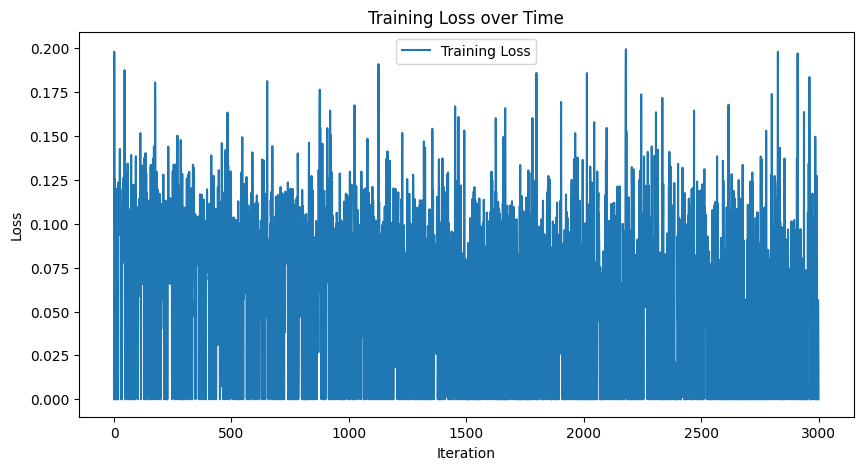

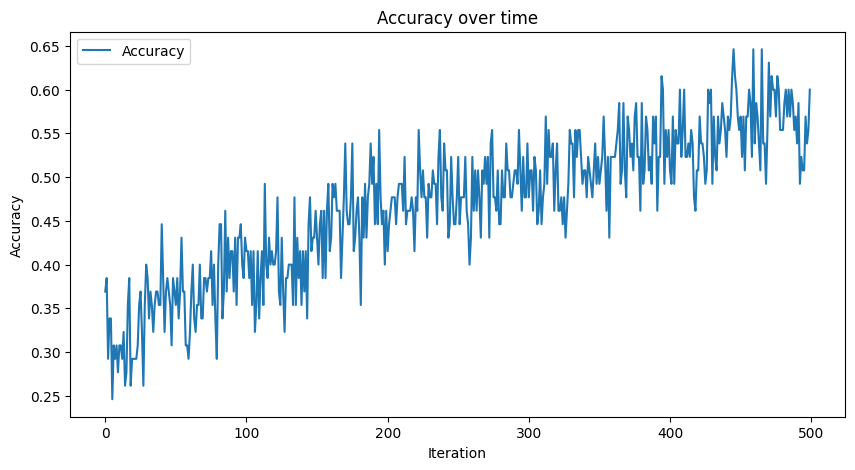

In [14]:
plot_loss_history(loss_history)
plot_accuracy_history(acc)

# Построение emdending space

100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


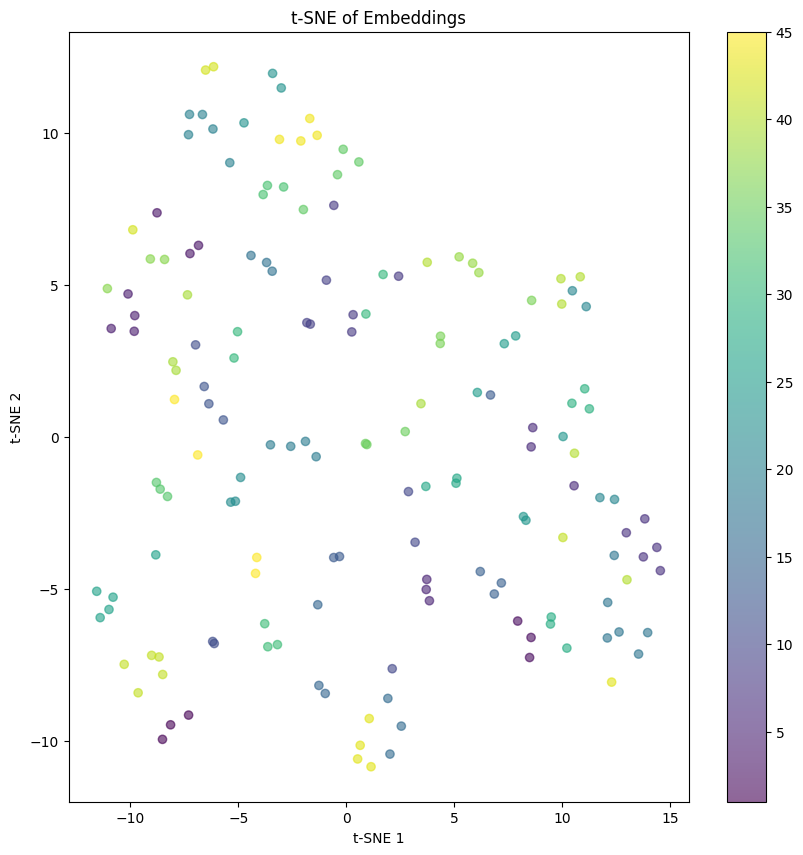

In [18]:
from sklearn.manifold import TSNE

def plot_tsne(train_dataset, val_dataset, model):
    model.eval()
    train_embeddings, train_labels = get_all_embeddings(train_dataset, model)
    val_embeddings, val_labels = get_all_embeddings(val_dataset, model)

    all_embeddings = torch.cat([train_embeddings, val_embeddings], dim=0).to(device)
    all_labels = torch.cat([train_labels, val_labels], dim=0).cpu().numpy()

    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(all_embeddings.cpu().numpy())

    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=all_labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('t-SNE of Embeddings')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

plot_tsne(train_dataset, val_dataset, model)

In [22]:
# Функция для вычисления процентного сходства на основе косинусного сходства
def cosine_similarity(embedding1, embedding2):
    return F.cosine_similarity(embedding1, embedding2).item() * 100

# Функция для получения векторного представления изображения
def get_embedding(model, image, transform, device):
    model.eval()
    with torch.no_grad():
        image = transform(image).unsqueeze(0).to(device)
        embedding = model(image)
    return embedding

# Функция для вычисления среднее процентного сходства с эталонными изображениями того же класса
def calculate_average_similarity(model, train_loader, val_loader, device):
    model.eval()
    with torch.no_grad():
        train_embeddings = []
        train_labels = []
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            embeddings = model(data)
            train_embeddings.append(embeddings)
            train_labels.append(labels)
        train_embeddings = torch.cat(train_embeddings)
        train_labels = torch.cat(train_labels)

        similarities = []
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            test_embeddings = model(data)
            for test_embedding, label in zip(test_embeddings, labels):
                same_class_indices = (train_labels == label).nonzero(as_tuple=True)[0]
                same_class_embeddings = train_embeddings[same_class_indices]
                cosine_similarities = F.cosine_similarity(test_embedding.unsqueeze(0), same_class_embeddings)
                avg_similarity = cosine_similarities.mean().item() * 100
                similarities.append(avg_similarity)
                print(f"Label: {label.item()}, Average Similarity: {avg_similarity:.2f}%")
    return similarities

# Вычисление процентного сходства для валидационного набора данных
average_similarities = calculate_average_similarity(model, train_loader, val_loader, device)

Label: 41, Average Similarity: 9.81%
Label: 41, Average Similarity: 71.52%
Label: 44, Average Similarity: 72.36%
Label: 22, Average Similarity: 81.73%
Label: 34, Average Similarity: 85.51%
Label: 14, Average Similarity: 79.01%
Label: 10, Average Similarity: 63.81%
Label: 30, Average Similarity: 61.14%
Label: 28, Average Similarity: 70.51%
Label: 43, Average Similarity: 69.22%
Label: 26, Average Similarity: 48.07%
Label: 16, Average Similarity: 75.01%
Label: 23, Average Similarity: 41.40%
Label: 20, Average Similarity: 59.13%
Label: 44, Average Similarity: 85.78%
Label: 13, Average Similarity: 49.91%
Label: 32, Average Similarity: 75.06%
Label: 42, Average Similarity: 53.61%
Label: 31, Average Similarity: 85.81%
Label: 4, Average Similarity: 85.07%
Label: 37, Average Similarity: 32.60%
Label: 19, Average Similarity: 66.49%
Label: 7, Average Similarity: 65.38%
Label: 18, Average Similarity: 43.24%
Label: 25, Average Similarity: 39.47%
Label: 35, Average Similarity: 33.84%
Label: 33, Aver

# Сохранение модели

In [20]:
torch.save(model.state_dict(), 'trained_model.pth')
print("Model saved as trained_model.pth")

Model saved as trained_model.pth
